In [1]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en-IN;q=0.9,en;q=0.8,kn;q=0.7,mr;q=0.6" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10151/59042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1582272766&Signature=S6qE71BL07Wu6xF%2FnjB5a%2BfUWp6mwHPamqrShvMnYghPeA9d7pljEsLtReDCGj0DrH4ES1XDPzBpFp0bTEDFL3Df%2FUIcuZaEuDf%2BD0m3P5AerzqZVU70lvsP9YKJ3%2Bp%2F1LYSb6vbB%2Fq0HKpxZRIbVO%2FFw3J5ntAxsXPFfZOX%2FKUi4%2F%2BEMfaqC9cMsIZg2xpBEd2WNTIe6uxMIEBlKYJYCmfmVZIqtKsRor1rGmBmKS%2F5NcTojHKSileL4aW2VFhobIuNZybO7wermMS5sMtR4IVcy4B53GHpyttfQx748nBTLWaSLxQRJ0aBFZ6FppYn0aBDk6EAKlRBOMLDImvKMQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtgs-salt-identification-challenge.zip" -O "tgs-salt-identification-challenge.zip" -c

--2020-02-21 06:23:41--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10151/59042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1582272766&Signature=S6qE71BL07Wu6xF%2FnjB5a%2BfUWp6mwHPamqrShvMnYghPeA9d7pljEsLtReDCGj0DrH4ES1XDPzBpFp0bTEDFL3Df%2FUIcuZaEuDf%2BD0m3P5AerzqZVU70lvsP9YKJ3%2Bp%2F1LYSb6vbB%2Fq0HKpxZRIbVO%2FFw3J5ntAxsXPFfZOX%2FKUi4%2F%2BEMfaqC9cMsIZg2xpBEd2WNTIe6uxMIEBlKYJYCmfmVZIqtKsRor1rGmBmKS%2F5NcTojHKSileL4aW2VFhobIuNZybO7wermMS5sMtR4IVcy4B53GHpyttfQx748nBTLWaSLxQRJ0aBFZ6FppYn0aBDk6EAKlRBOMLDImvKMQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtgs-salt-identification-challenge.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 466124588 (445M) [application/zip]
Saving to: ‘tgs-salt-identification-

In [2]:
!unzip '/content/tgs-salt-identification-challenge.zip'
from zipfile import ZipFile
zf = ZipFile('train.zip', 'r')
zf.extractall('../content/train')
zf.close()
from zipfile import ZipFile
zf = ZipFile('test.zip', 'r')
zf.extractall('../content/test')
zf.close()

Archive:  /content/tgs-salt-identification-challenge.zip
  inflating: competition_data.zip    
  inflating: depths.csv              
  inflating: flamingo.zip            
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [0]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import time
t_start = time.time()

In [37]:
version = 4
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v4.model
Unet_resnet_v4.csv


In [0]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

## Data Processing

In [39]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [40]:
train_df["images"] = [np.array(load_img("train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [41]:
train_df["masks"] = [np.array(load_img("train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

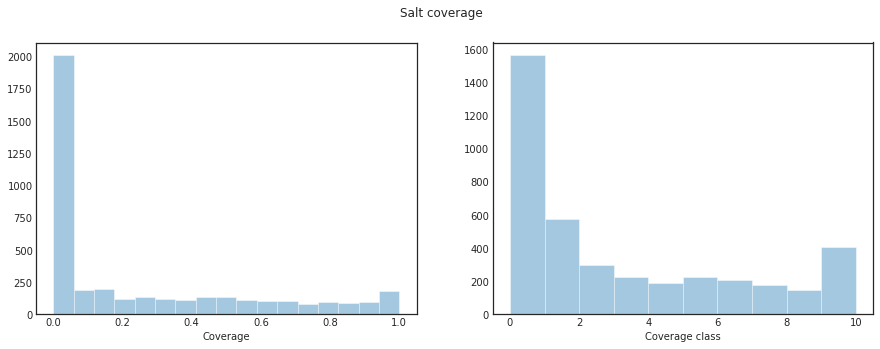

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5, 1.0, 'Depth distribution')

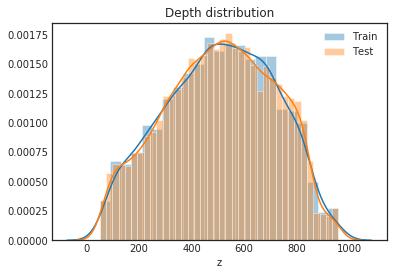

In [44]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [0]:
# Create train/validation split stratified by salt coverage
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
train_test_split(train_df.index.values, 
                 np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
                 np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
                 train_df.coverage.values, 
                 train_df.z.values, 
                 test_size=0.2, stratify=train_df.coverage_class, random_state=555)

### Unet Model

In [0]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [0]:
# Build Model
def build_model(input_layer, start_neurons, DropoutRatio=0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(input_layer)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    
    # 50 -> 25
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 25 -> 12
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    
    # 12 -> 6
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # Middle
    convm = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    convm = residual_block(convm, start_neurons*16)
    convm = residual_block(convm, start_neurons*16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='valid')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='valid')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [0]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [0]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

### Data Augmentation

In [0]:
#Adding Gaussian Noise 
import numpy as np
import os
import cv2
def noisy(noise_typ,image):
    
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      #0.0001=0.783
      var = 0.0001
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy

In [51]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
x_train = np.append(x_train, [noisy("gauss",x) for x in x_train[0:3200]], axis=0)
y_train = np.append(y_train, [x for x in y_train[0:3200]], axis=0)

print(x_train.shape)
print(y_valid.shape)

(9600, 101, 101, 1)
(800, 101, 101, 1)


In [52]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.005)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 101, 101, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 101, 101, 16) 64          conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 101, 101, 16) 0           batch_normalization_46[0][0]     
____________________________________________________________________________________________

In [19]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name, monitor='my_iou_metric', mode='max',
                                   save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=5,
                              min_lr=0.0001, verbose=1)

epochs = 100
batch_size = 128

t_model1_start = time.time()
history = model1.fit(x_train, y_train,
                     validation_data = [x_valid, y_valid], 
                     epochs = epochs, 
                     batch_size = batch_size, 
                     callbacks = [early_stopping, model_checkpoint, reduce_lr],
                     verbose = 2)
t_model1_end = time.time()
print(f"Run time = {(t_model1_end-t_model1_start)/3600} hours")



Train on 6400 samples, validate on 800 samples
Epoch 1/100
 - 35s - loss: 0.4844 - my_iou_metric: 0.2327 - val_loss: 8.7015 - val_my_iou_metric: 0.0604

Epoch 00001: my_iou_metric improved from -inf to 0.23270, saving model to Unet_resnet_v4.model
Epoch 2/100
 - 18s - loss: 0.3532 - my_iou_metric: 0.4593 - val_loss: 1.0887 - val_my_iou_metric: 0.3900

Epoch 00002: my_iou_metric improved from 0.23270 to 0.45933, saving model to Unet_resnet_v4.model
Epoch 3/100
 - 18s - loss: 0.2898 - my_iou_metric: 0.5269 - val_loss: 3.9443 - val_my_iou_metric: 0.3900

Epoch 00003: my_iou_metric improved from 0.45933 to 0.52691, saving model to Unet_resnet_v4.model
Epoch 4/100
 - 18s - loss: 0.2718 - my_iou_metric: 0.5294 - val_loss: 0.9441 - val_my_iou_metric: 0.1485

Epoch 00004: my_iou_metric improved from 0.52691 to 0.52944, saving model to Unet_resnet_v4.model
Epoch 5/100
 - 18s - loss: 0.2501 - my_iou_metric: 0.5310 - val_loss: 0.5377 - val_my_iou_metric: 0.3044

Epoch 00005: my_iou_metric impro

In [20]:
model1 = load_model(save_model_name, custom_objects={'my_iou_metric':my_iou_metric})
# remove activation layer and use lovasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr=0.01)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [21]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=30, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, 
                              min_lr=0.00005, verbose=1)
epochs = 120
batch_size = 64

t_model2_start = time.time()
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=2)
t_model2_end = time.time()
print(f"Run time = {(t_model2_end-t_model2_start)/3600} hours")

Train on 6400 samples, validate on 800 samples
Epoch 1/120
 - 40s - loss: 0.3792 - my_iou_metric_2: 0.6758 - val_loss: 0.3556 - val_my_iou_metric_2: 0.6901

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.69013, saving model to Unet_resnet_v4.model
Epoch 2/120
 - 27s - loss: 0.2899 - my_iou_metric_2: 0.6967 - val_loss: 0.7510 - val_my_iou_metric_2: 0.5933

Epoch 00002: val_my_iou_metric_2 did not improve from 0.69013
Epoch 3/120
 - 27s - loss: 0.2528 - my_iou_metric_2: 0.7026 - val_loss: 1.8574 - val_my_iou_metric_2: 0.3139

Epoch 00003: val_my_iou_metric_2 did not improve from 0.69013
Epoch 4/120
 - 27s - loss: 0.1999 - my_iou_metric_2: 0.7180 - val_loss: 0.6765 - val_my_iou_metric_2: 0.6096

Epoch 00004: val_my_iou_metric_2 did not improve from 0.69013
Epoch 5/120
 - 27s - loss: 0.1333 - my_iou_metric_2: 0.7320 - val_loss: 0.4627 - val_my_iou_metric_2: 0.6630

Epoch 00005: val_my_iou_metric_2 did not improve from 0.69013
Epoch 6/120
 - 27s - loss: 0.1073 - my_iou_metric_2: 0

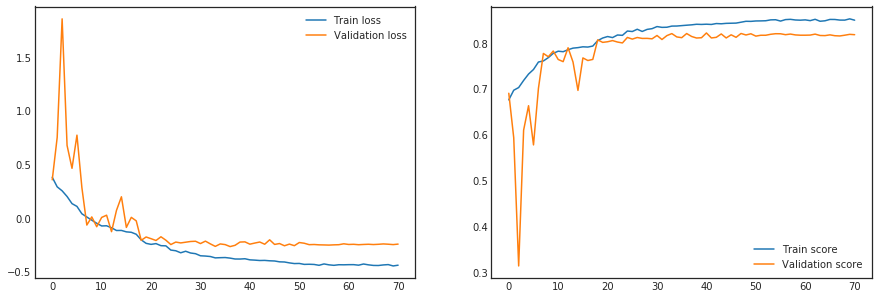

In [22]:
#plotting train vs validation loss
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [0]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [0]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [0]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [0]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [27]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.



[0.816375 0.818125 0.819125 0.820125 0.820625 0.822625 0.823875 0.825375
 0.825125 0.825    0.8265   0.82675  0.827125 0.826375 0.826875 0.8265
 0.826875 0.826    0.825375 0.824875 0.823625 0.822625 0.821875 0.82125
 0.8215   0.821125 0.820375 0.819875 0.81925  0.82     0.819   ]


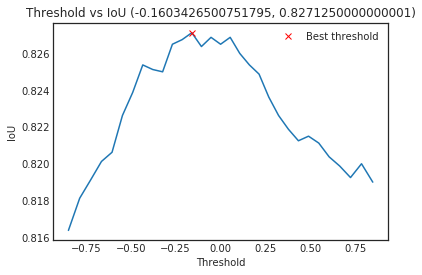

In [28]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [0]:
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [64]:
x_test = np.array([(np.array(load_img("test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
preds_test = predict_result(model,x_test,img_size_target)

In [66]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

We get 0.84 iou on test data on kaggle private leaderboard

Observation
1. We split the train data into train and validation stratified by depth column in 80:20 split and do analysis on the data.
2. We do augmentation on data like flip and adding noise.
3. We use unet model with resnet for training with mean_iou and lovasz loss as eval metric with early stopping and get a loss of 0.82 on validation set.
4. We save the model and predict on validation set and find the best threshold which gives the maximum iou for validation set.
5. We now use the threshold and model to predict on test set and submit and get a score of 0.840.